In [52]:
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph


def generate_assortative():
    partition_sizes = [40, 30]

    probs = [[0.6, 0.2], [0.2, 0.6]]

    g = nx.stochastic_block_model(partition_sizes, probs, seed=0)

    node_to_community = dict()
    node = 0
    for community_id, size in enumerate(partition_sizes):
        for _ in range(size):
            node_to_community[node] = community_id
            node += 1

    # # alternatively, we can infer the best partition using Louvain:
    # from community import community_louvain
    # node_to_community = community_louvain.best_partition(g)

    community_to_color = {
        0 : 'tab:red',
        1 : 'tab:green',
    }
    node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

    Graph(g,
          node_color=node_color, node_edge_width=0, edge_alpha=0.1, node_size=2,
          node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
          edge_layout='straight', edge_layout_kwargs=dict(k=2000),
    )

    
    
def generate_bipartite():
    partition_sizes = [20, 15,]

    g = nx.bipartite.random_graph(partition_sizes[0], partition_sizes[1], 0.6)
    node_to_community = dict()
    node = 0
    community = {}
    for community_id, size in enumerate(partition_sizes):
        for _ in range(size):
            node_to_community[node] = community_id
            curr = community.get(community_id, [])
            curr.append(node)
            community[community_id] = curr
            node += 1

    community_to_color = {
        0 : 'tab:red',
        1 : 'tab:green',
    }
    node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

    Graph(g, 
          node_size=1, node_color = node_color, node_edge_color = node_color, edge_alpha=0.1,
          node_layout='bipartite', node_layout_kwargs=dict(subsets=[community[0], community[1]]),
          edge_layout = "straight", edge_layout_kwargs=dict(k=2000),
         )
    

def generate_core_periphery():
    partition_sizes = [40, 30]

    probs = [[0.8, 0.2], [0.2, 0.01]]

    g = nx.stochastic_block_model(partition_sizes, probs, seed=0)

    node_to_community = dict()
    node = 0
    for community_id, size in enumerate(partition_sizes):
        for _ in range(size):
            node_to_community[node] = community_id
            node += 1

    community_to_color = {
        0 : 'tab:red',
        1 : 'tab:green',
    }
    node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

    Graph(g,
          node_color=node_color, node_edge_width=0, edge_alpha=0.05, node_size=1,
    )
    
def generate_random_graph():
    g = nx.erdos_renyi_graph(70, 0.3, )
    Graph(g,
          node_color="green", node_edge_width=0, edge_alpha=0.05, node_size=1,
    )


import seaborn as sns
import pandas as pd

def plot_matrix(prob):
    #prob = [0.6, 0.4, 0.4, 0.1]
    columns = {"g1":["g1", "g1", "g2", "g2"], "g2":["g1", "g2", "g1", "g2"], "p":prob}
    df = pd.DataFrame(columns)
    pivot = df.pivot("g1", "g2", "p")
    sns.heatmap(pivot, cmap='Greys', vmin=0, vmax=1, yticklabels=False, xticklabels=False, cbar=False)
    plt.xlabel("")
    plt.ylabel("")

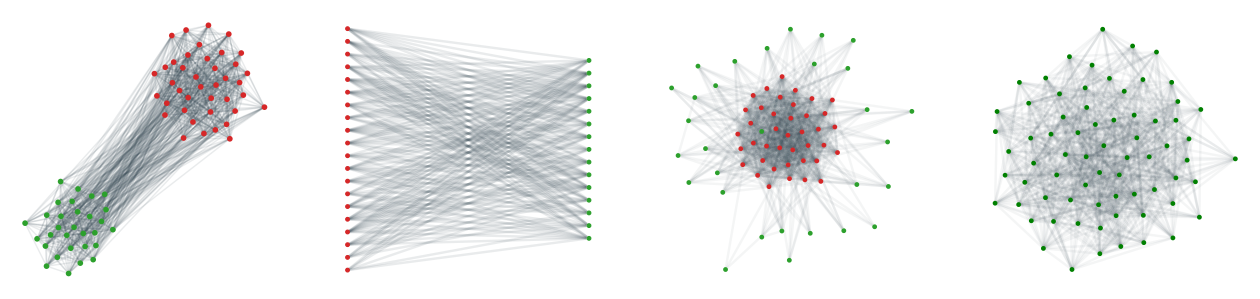

In [53]:
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(141)
generate_assortative()

plt.subplot(142)
generate_bipartite()

plt.subplot(143)
generate_core_periphery()

plt.subplot(144)
generate_random_graph()

/tmp/ipykernel_18865/4187715828.py:104: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = df.pivot("g1", "g2", "p")


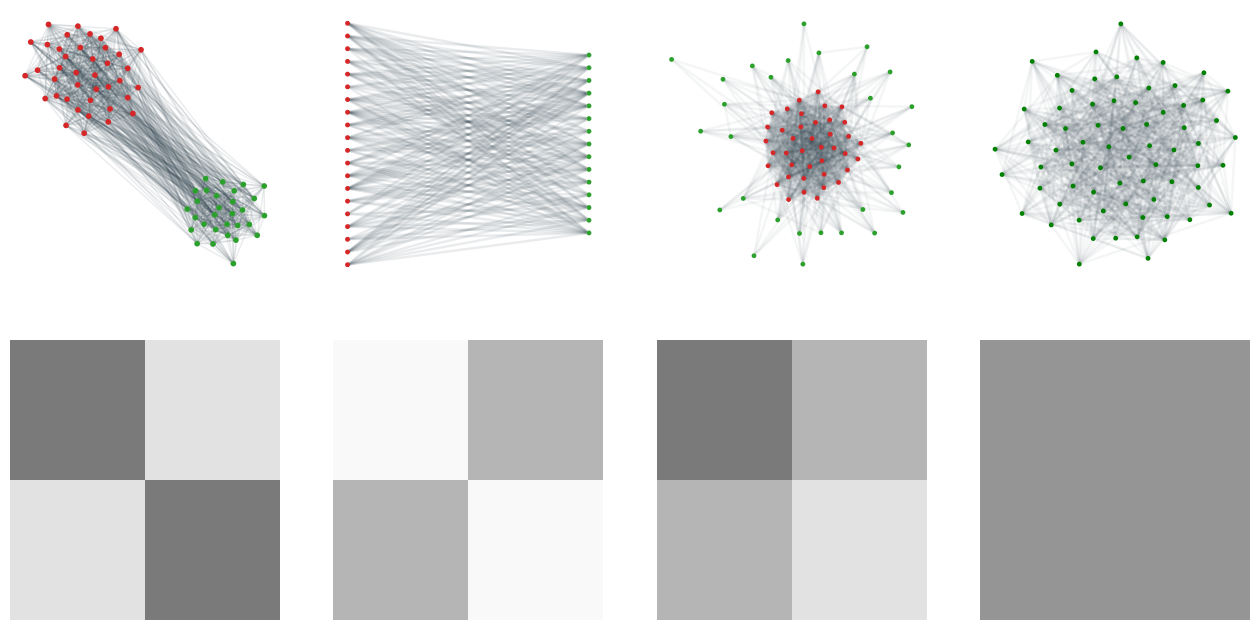

In [54]:
plt.rcParams["figure.figsize"] = (16,8)

plt.subplot(241)
generate_assortative()

plt.subplot(242)
generate_bipartite()

plt.subplot(243)
generate_core_periphery()

plt.subplot(244)
generate_random_graph()

plt.subplot(245)
plot_matrix([0.6, 0.2, 0.2, 0.6])

plt.subplot(246)
plot_matrix([0.05, 0.4, 0.4, 0.05])

plt.subplot(247)
plot_matrix([0.6, 0.4, 0.4, 0.2])

plt.subplot(248)
plot_matrix([0.5, 0.5, 0.5, 0.5])

plt.savefig("SBM_representations.pdf", bbox_inches="tight", dpi=200)

# 2. Examples

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    g = nx.karate_club_graph()
    partition = community_louvain.best_partition(g)
    pos = community_layout(g, partition)

    nx.draw(g, pos, node_color=list(partition.values())); plt.show()
    return


In [53]:
#plot assortative structure

/home/anav/working_projects/StackExchange-communities/.venv/lib/python3.8/site-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]


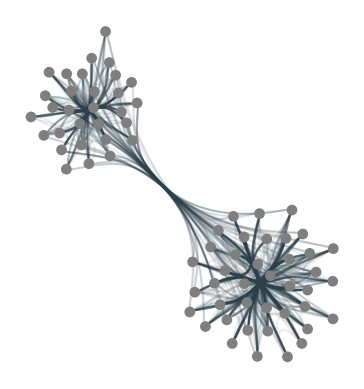

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# installation easiest via pip:
# pip install netgraph
from netgraph import Graph

# create a modular graph
partition_sizes = [30, 40,]
g = nx.random_partition_graph(partition_sizes, 0.8, 0.1)

# since we created the graph, we know the best partition:
node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1

# # alternatively, we can infer the best partition using Louvain:
# from community import community_louvain
# node_to_community = community_louvain.best_partition(g)

community_to_color = {
    0 : 'tab:gray',
    1 : 'tab:gray',
    #2 : 'tab:green',
    #3 : 'tab:red',
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(g,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)

plt.show()

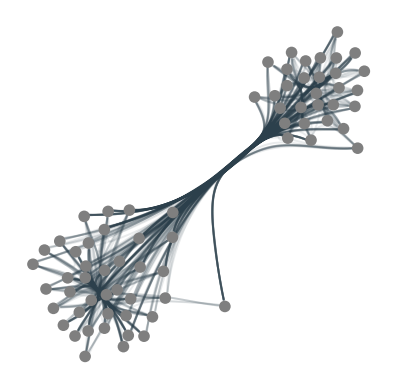

In [6]:
sizes = [40, 30]

probs = [[0.6, 0.2], [0.2, 0.6]]

g = nx.stochastic_block_model(sizes, probs, seed=0)


node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1

# # alternatively, we can infer the best partition using Louvain:
# from community import community_louvain
# node_to_community = community_louvain.best_partition(g)

community_to_color = {
    0 : 'tab:gray',
    1 : 'tab:gray',
    #2 : 'tab:green',
    #3 : 'tab:red',
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(g,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# installation easiest via pip:
# pip install netgraph
from netgraph import Graph

# create a modular graph
partition_sizes = [30, 40,]
g = nx.random_partition_graph(partition_sizes, 0.1, 0.)

# since we created the graph, we know the best partition:
node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1

# # alternatively, we can infer the best partition using Louvain:
# from community import community_louvain
# node_to_community = community_louvain.best_partition(g)

community_to_color = {
    0 : 'tab:gray',
    1 : 'tab:gray',
    #2 : 'tab:green',
    #3 : 'tab:red',
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(g,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)

plt.show()

KeyboardInterrupt: 

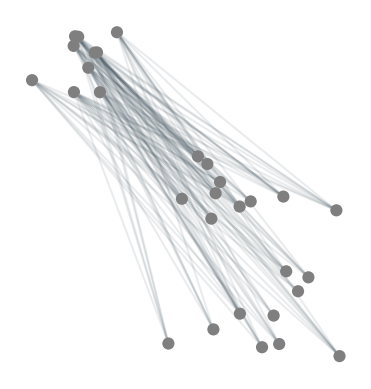

In [52]:
partition_sizes = [20, 10,]

g = nx.bipartite.random_graph(partition_sizes[0], partition_sizes[1], 0.6)
node_to_community = dict()
node = 0
community = {}
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        curr = community.get(community_id, [])
        curr.append(node)
        community[community_id] = curr
        node += 1

node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(g,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='straight', edge_layout_kwargs=dict(k=2000),
)

plt.show()

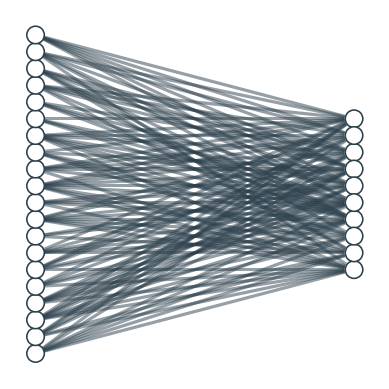

In [47]:
partition_sizes = [20, 10,]

g = nx.bipartite.random_graph(partition_sizes[0], partition_sizes[1], 0.6)
node_to_community = dict()
node = 0
community = {}
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        curr = community.get(community_id, [])
        curr.append(node)
        community[community_id] = curr
        node += 1
        
Graph(g,
      nodes_size=10, 
      node_layout='bipartite', node_layout_kwargs=dict(subsets=[community[0], community[1]]))
plt.show()

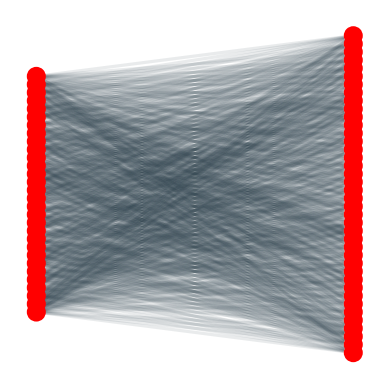

In [48]:
help(Graph)

Help on class Graph in module netgraph._main:

class Graph(BaseGraph)
 |  Graph(graph, edge_cmap='RdGy', *args, **kwargs)
 |  
 |  Parses the given graph data object and initialises the BaseGraph object.
 |  
 |  If the given graph includes edge weights, then these are mapped to colors using the `edge_cmap` parameter.
 |  
 |  Parameters
 |  ----------
 |  graph : various formats
 |      Graph object to plot. Various input formats are supported.
 |      In order of precedence:
 |  
 |      - Edge list:
 |        Iterable of (source, target) or (source, target, weight) tuples,
 |        or equivalent (E, 2) or (E, 3) ndarray, where E is the number of edges.
 |      - Adjacency matrix:
 |        Full-rank (V, V) ndarray, where V is the number of nodes/vertices.
 |        The absence of a connection is indicated by a zero.
 |  
 |        .. note:: If V <= 3, any (2, 2) or (3, 3) matrices will be interpreted as edge lists.**
 |  
 |      - networkx.Graph, igraph.Graph, or graph_tool.Graph 